In [512]:
import csv
from itertools import groupby
from typing import NamedTuple, Dict, Tuple
import matplotlib.pyplot as plt

class LookupEntry(NamedTuple):
    absolute: float
    relative: float
    win: int
    rank: int
    race: str
    opp_race: str

class InfoEntry(NamedTuple):
    uid: str
    pid: str
    race: str
    rank: int
    win: int

def bucket(val, size):
    return val // size * size

def convert_rank(rank):
    return int(rank) if rank in ['1', '2', '3', '4', '5', '6', '7'] else 0

def filename_to_gameid(replay_file):
    game_id = replay_file.split("_")[1].split(".")[0]
    if replay_file.startswith("ggg"):
        game_id = "ggg-" + game_id
    elif replay_file.startswith("spawningtool"):
        game_id = "st-" + game_id
    elif replay_file.startswith("dropsc"):
        game_id = "ds-" + game_id
    return game_id

with open("replays_info_game_length.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
# there's one replay that doesn't have rank information...
infos = {filename_to_gameid(line["ReplayID"]): {
    line["UID1"]: InfoEntry(line["UID1"], "1", line["Race1"], convert_rank(line["Rank1"]), 
                            1 if line["Winner"] == "1" else 0),
    line["UID2"]: InfoEntry(line["UID2"], "2", line["Race2"], convert_rank(line["Rank2"]), 
                            1 if line["Winner"] == "2" else 0),
    "GameLength": float(line["GameLengthSeconds"])
} for line in lines if len(line["Rank1"]) > 0}

with open("sc2_prediction_data-2021-08-08.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
stats = {key: list(g) for key, g in 
         groupby(sorted(lines, key=lambda x: x['GameID']), 
                 lambda x: x['GameID'])}

APM_BUCKET_SIZE = 5
CPM_BUCKET_SIZE = 1
apm_lookup = {}
cpm_lookup = {}
for game, s in stats.items():
    assert len(s) == 2
    assert game in infos
    assert s[0]['UID'] in infos[game]
#     assert int(s[0]["Win"]) == infos[game][s[0]['UID']].win, f"{int(s[0]['Win'])} {infos[game][s[0]['UID']].win}" 
    assert convert_rank(s[0]["Rank"]) == infos[game][s[0]['UID']].rank or convert_rank(s[0]["Rank"]) == 7, f"{s[0]}\n{infos[game][s[0]['UID']]}"
    assert s[1]['UID'] in infos[game]
#     assert int(s[1]["Win"]) == infos[game][s[1]['UID']].win, f"{int(s[1]['Win'])} {infos[game][s[1]['UID']].win}"     
    assert convert_rank(s[1]["Rank"]) == infos[game][s[1]['UID']].rank  or convert_rank(s[1]["Rank"]) == 7
    apm_lookup[(s[0]['UID'], s[0]['GameID'])] = LookupEntry(bucket(float(s[0]["APM"]), APM_BUCKET_SIZE), 
                                                            bucket(float(s[0]["APM"]) - float(s[1]["APM"]), 
                                                                   APM_BUCKET_SIZE), 
                                                            int(s[0]["Win"]),
                                                            convert_rank(s[0]["Rank"]),
                                                            infos[game][s[0]['UID']].race, 
                                                            infos[game][s[1]['UID']].race)
    apm_lookup[(s[1]['UID'], s[1]['GameID'])] = LookupEntry(bucket(float(s[1]["APM"]), APM_BUCKET_SIZE), 
                                                            bucket(float(s[1]["APM"]) - float(s[0]["APM"]), 
                                                                   APM_BUCKET_SIZE), 
                                                            int(s[1]["Win"]),
                                                            convert_rank(s[1]["Rank"]),
                                                            infos[game][s[1]['UID']].race, 
                                                            infos[game][s[0]['UID']].race)
    cpm0 = float(s[0]["CPS"]) * 60
    cpm1 = float(s[1]["CPS"]) * 60
    cpm_lookup[(s[0]['UID'], s[0]['GameID'])] = LookupEntry(bucket(cpm0, CPM_BUCKET_SIZE), 
                                                            bucket(cpm0 - cpm1, CPM_BUCKET_SIZE), 
                                                            int(s[0]["Win"]),
                                                            convert_rank(s[0]["Rank"]),
                                                            infos[game][s[0]['UID']].race, 
                                                            infos[game][s[1]['UID']].race)
    cpm_lookup[(s[1]['UID'], s[1]['GameID'])] = LookupEntry(bucket(cpm1, CPM_BUCKET_SIZE), 
                                                            bucket(cpm1 - cpm0, CPM_BUCKET_SIZE), 
                                                            int(s[1]["Win"]),
                                                            convert_rank(s[1]["Rank"]),
                                                            infos[game][s[1]['UID']].race, 
                                                            infos[game][s[0]['UID']].race)

def count_scouting(scouting, gameid, uid, pred=lambda x: True):
    return len([x for x in scouting.get(gameid, []) if x['UID'] == uid and pred(x)])
    

with open("scouting_instances-2021-08-11.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
scouting = {key: list(g) for key, g in 
            groupby(sorted(lines, key=lambda x: x['GameID']), 
                    lambda x: x['GameID']) if key in stats}

In [440]:
print(Counter([abs(convert_rank(x[0]["Rank"]) - convert_rank(x[1]["Rank"])) for x in stats.values() if x[0]["Rank"] != x[1]["Rank"] and x[0]["Rank"] != "nan" and x[1]["Rank"] != "nan"]))
print(len([x for x in stats.values() if x[0]["Rank"] != x[1]["Rank"] and x[0]["Rank"] != "nan" and x[1]["Rank"] != "nan"])/len(stats))
len([x for x in stats.values() if x[0]["Rank"] != x[1]["Rank"] and x[0]["Rank"] != "nan" and x[1]["Rank"] != "nan" and max(x, key=lambda s: convert_rank(s["Rank"]))["Win"] == '1'])/len([x for x in stats.values() if x[0]["Rank"] != x[1]["Rank"] and x[0]["Rank"] != "nan" and x[1]["Rank"] != "nan"])


Counter({1: 16483, 2: 1939, 3: 488, 4: 174, 5: 20})
0.2430225162193105


0.5654313232830821

In [403]:
scouting_lookup = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    count0 = count_scouting(scouting, game, stat0['UID'])
    count1 = count_scouting(scouting, game, stat1['UID'])
    scouting_lookup[(stat0['UID'], stat0['GameID'])] = LookupEntry(count0, count0 - count1, 
                                                                   int(stat0["Win"]),
                                                                   convert_rank(stat0["Rank"]),
                                                                   infos[game][stat0['UID']].race, 
                                                                   infos[game][stat1['UID']].race)
    scouting_lookup[(stat1['UID'], stat1['GameID'])] = LookupEntry(count1, count1 - count0,
                                                                   int(stat1["Win"]),
                                                                   convert_rank(stat1["Rank"]),
                                                                   infos[game][stat1['UID']].race,
                                                                   infos[game][stat0['UID']].race)
scouting_lookup_no_engage = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    count0 = count_scouting(scouting, game, stat0['UID'], 
                            lambda x: x["DuringEngagement"] == "False")
    count1 = count_scouting(scouting, game, stat1['UID'], 
                            lambda x: x["DuringEngagement"] == "False")
    scouting_lookup_no_engage[(stat0['UID'], stat0['GameID'])] = LookupEntry(count0, count0 - count1, 
                                                                   int(stat0["Win"]),
                                                                   convert_rank(stat0["Rank"]),
                                                                   infos[game][stat0['UID']].race, 
                                                                   infos[game][stat1['UID']].race)
    scouting_lookup_no_engage[(stat1['UID'], stat1['GameID'])] = LookupEntry(count1, count1 - count0,
                                                                   int(stat1["Win"]),
                                                                   convert_rank(stat1["Rank"]),
                                                                   infos[game][stat1['UID']].race,
                                                                   infos[game][stat0['UID']].race)

In [542]:
scouting_rate_lookup_noengage = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    count0 = count_to_rate(game, count_scouting(scouting, game, stat0['UID'], 
                            lambda x: x["DuringEngagement"] == "False"))
    count1 = count_to_rate(game, count_scouting(scouting, game, stat1['UID'], 
                            lambda x: x["DuringEngagement"] == "False"))
    scouting_rate_lookup_noengage[(stat0['UID'], stat0['GameID'])] = LookupEntry(count0, round(count0 - count1, 3),
                                                                   int(stat0["Win"]),
                                                                   convert_rank(stat0["Rank"]),
                                                                   infos[game][stat0['UID']].race, 
                                                                   infos[game][stat1['UID']].race)
    scouting_rate_lookup_noengage[(stat1['UID'], stat1['GameID'])] = LookupEntry(count1, round(count1 - count0, 3),
                                                                   int(stat1["Win"]),
                                                                   convert_rank(stat1["Rank"]),
                                                                   infos[game][stat1['UID']].race,
                                                                   infos[game][stat0['UID']].race)

In [463]:
def make_boxplot(series, categories, ylabel, filename, ylims=None, yscale="linear", markers=None):
    assert len(series) == len(categories), \
        "Each series must have a category label (provided {} series and {} categories)".format(len(series), len(categories))
    plt.clf()
    fig, ax = plt.subplots(figsize=(2 * len(series), 4))

    for i, s in enumerate(series, 1):
        x = np.random.normal(i, 0.04, size=len(s))
        if markers:
            for mark, mask in markers.items():
                plt.plot(np.array(x)[mask], np.array(s)[mask], mark, alpha=0.2)
        else:
            plt.plot(x, s, 'r.', alpha=0.2)
    
    bp = plt.boxplot(series, sym='b+')
    # bp['boxes'][0].set_facecolor(colors[0])
    # bp['boxes'][1].set_facecolor(colors[1])
    plt.setp(bp['medians'], color='black', linewidth='2.5')

    ax.set_yscale(yscale)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    # plt.legend((bp['boxes'][0], bp['boxes'][1]), categories)

    # plt.tick_params(
    #     axis='x',  # changes apply to the x-axis
    #     which='both',  # both major and minor ticks are affected
    #     bottom='off',  # ticks along the bottom edge are off
    #     top='off',  # ticks along the top edge are off
    #     labelbottom='off')  # labels along the bottom edge are off
    plt.setp(ax, xticklabels=categories)
    if ylims:
        plt.ylim(*ylims)
    plt.ylabel("\n".join(wrap(ylabel, 60)))
    plt.tight_layout()
#     plt.savefig(filename)
#     plt.close()
scouting_duration = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    d = scouting_duration.setdefault(convert_rank(stat0["Rank"]), [])
    scouts = [(int(x["ScoutingEndTime"]) - int(x["ScoutingStartTime"])) for x in s if x['UID'] == stat0['UID']]
    if len(scouts) > 0:
#         d.append(np.mean(scouts))
        d.append(len([x for x in scouts if x < 230]) / len(scouts))
    d = scouting_duration.setdefault(convert_rank(stat1["Rank"]), [])
    scouts = [(int(x["ScoutingEndTime"]) - int(x["ScoutingStartTime"])) for x in s if x['UID'] == stat1['UID']]
    if len(scouts) > 0:
#         d.append(np.mean(scouts))
        d.append(len([x for x in scouts if x < 230]) / len(scouts))
for rank, times in sorted(scouting_duration.items()):
    print(rank, np.mean(times))
print(np.mean(sum([v for k,v in scouting_duration.items() if k != 7], [])))
# ranks, times = zip(*sorted(scouting_duration.items()))
# make_boxplot(times, ranks, "a", "a")

0 0.42786266113307697
1 0.3908856216004586
2 0.37904454391242864
3 0.40898536347804504
4 0.4304401033914609
5 0.4472495429492693
6 0.426865637173881
7 0.43461027741395253
0.427892014356709


In [528]:
scouting_no_engage = {game: [x for x in s if x["DuringEngagement"] == "False"] for game, s in scouting.items()}

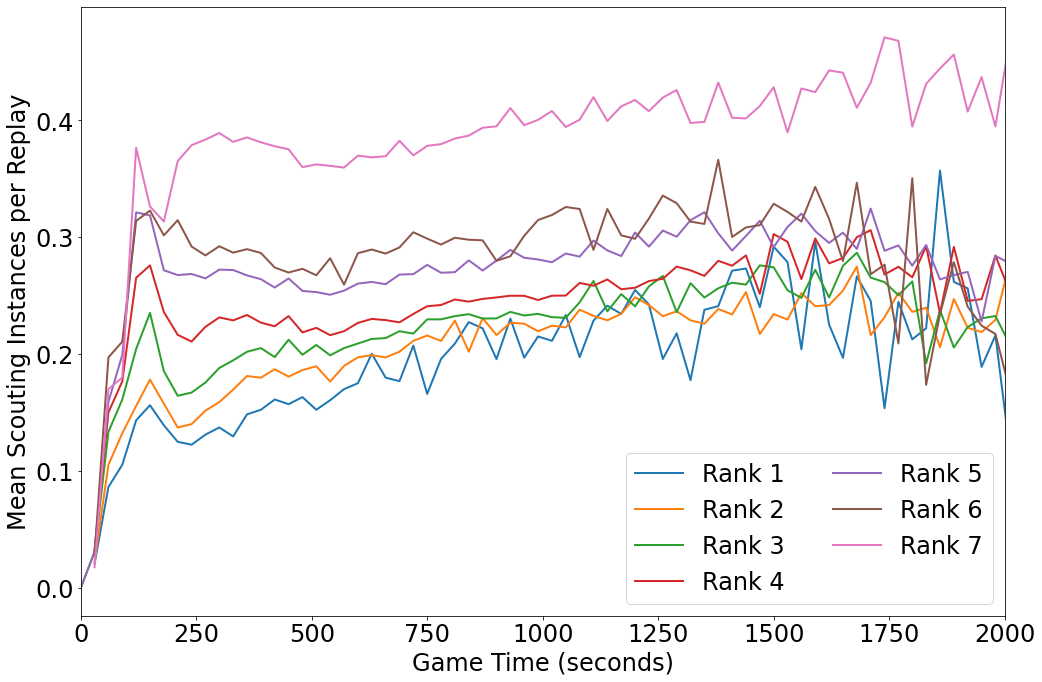

In [536]:
scouting_times = {}
rank_counts = {}
game_to_ranks = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    r = convert_rank(stat0["Rank"])
    game_to_ranks[game] = [r]
    d = scouting_times.setdefault(r, [])
    rank_counts[r] = rank_counts.setdefault(r, 0) + 1
    scouts = [bucket(int(x["ScoutingStartTime"])/22.4, 30) for x in s if x['UID'] == stat0['UID']]
    d.extend(scouts)
    r = convert_rank(stat1["Rank"])
    game_to_ranks[game].append(r)
    d = scouting_times.setdefault(r, [])
    rank_counts[r] = rank_counts.setdefault(r, 0) + 1
    scouts = [bucket(int(x["ScoutingStartTime"])/22.4, 30) for x in s if x['UID'] == stat1['UID']]
    d.extend(scouts)
# print(Counter(scouting_times[4]).most_common())
fig, ax = plt.subplots(figsize=(15,10))
lines = []
for rank, times in sorted(scouting_times.items()):
    if rank != 0:
        x, y = zip(*sorted(Counter(times).most_common()))
        y = np.array(y, dtype=np.float64)
        for i, xi in enumerate(x):
            d = len([r for game in scouting for r in game_to_ranks[game] if infos[game]["GameLength"] >= xi and r == rank])
#             print(y[i], d)
            y[i] /= d
#         print(y)
        lines.append(ax.plot(x, y, label=f"Rank {rank}", linewidth=2))
ax.legend(loc='lower right', ncol=2)
ax.set_xlim(0, 2000)
ax.set_xlabel("Game Time (seconds)")
ax.set_ylabel("Mean Scouting Instances per Replay")
plt.tight_layout()

In [415]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC

ranks = [1,2,4,5,7]
# X = np.array([np.mean([apm_lookup[x].absolute for x in g]) 
#               for _,g in groupby(sorted(apm_lookup.keys()), lambda k: k[0])])
# y = np.array([scipy.stats.mode([apm_lookup[x].rank for x in g]).mode.flatten()[0]
#               for _,g in groupby(sorted(apm_lookup.keys()), lambda k: k[0])])
X = np.array([[x.absolute - scouting_lookup_no_engage[k].absolute, 
               scouting_lookup_no_engage[k].absolute, 
               apm_lookup[k].absolute] for k,x in scouting_lookup.items() if x.rank in ranks])
y = np.array([x.rank for x in scouting_lookup.values() if x.rank in ranks])
# X = np.array([[x.relative - scouting_lookup_no_engage[k].relative, 
#                scouting_lookup_no_engage[k].relative, 
#                apm_lookup[k].relative] for k,x in scouting_lookup.items() if x.rank in [1,2,3,4,5,6,7]])
# y = np.array([x.win for x in scouting_lookup.values() if x.rank in [1,2,3,4,5,6,7]])
r = np.array([x.rank for x in scouting_lookup.values() if x.rank in ranks])
X_sample = []
y_sample = []
counter = {}
COUNT = 2000
for xi, yi, ri in zip(X, y, r):
    if counter.setdefault(ri, 0) < COUNT:
        X_sample.append(xi)
        y_sample.append(yi)
        counter[ri] += 1
X = np.array(X_sample)
y = np.array(y_sample)
# X = X[np.isin(y, [2, 3, 4, 5, 6, 7])]
# y = y[np.isin(y, [2, 3, 4, 5, 6, 7])]
# X = X[y != 0]
# y = y[y != 0]
y_skill = np.array([0 if r in [1,2] else 1 if r in [4,5] else 2 for r in y])
print(np.unique(y, return_counts=True))
print(np.unique(y_skill, return_counts=True))

# X = X.reshape(-1, 1)
# scaler = preprocessing.StandardScaler().fit(X)
# X = scaler.transform(X)

print(cross_val_score(GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=100, 
                                                 subsample=0.5, max_depth=5, 
                                                 learning_rate=0.01),
                      X, y_skill, 
                      cv=StratifiedKFold(n_splits=3), n_jobs=3))
clf = GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=100, 
                                                 subsample=0.5, max_depth=5, 
                                                 learning_rate=0.01)
clf.fit(X, y_skill)
print(clf.score(X, y_skill))
print(clf.score(X, y_skill) * len(X))
print((clf.predict(X) == y_skill).sum())
# X = np.array([[x.relative - scouting_lookup_no_engage[k].relative, 
#                scouting_lookup_no_engage[k].relative, 
#                apm_lookup[k].relative] for k,x in scouting_lookup.items() if x.rank in [1,2,3,4,5,6,7]])
# y = np.array([x.win for x in scouting_lookup.values() if x.rank in [1,2,3,4,5,6,7]])
# scaler = preprocessing.StandardScaler().fit(X)
# X = scaler.transform(X)
# print(clf.score(X, y))
# print(cross_val_score(RandomForestClassifier(n_estimators=1000),
#                       X, y, 
#                       cv=StratifiedKFold(n_splits=3), n_jobs=3))

(array([1, 2, 4, 5, 7]), array([1630, 2000, 2000, 2000, 2000]))
(array([0, 1, 2]), array([3630, 4000, 2000]))
[0.69750779 0.77445483 0.78878505]
0.7769470404984423
7482.0
7482


In [248]:
print(f"Median total scouting instances: {np.median([x.absolute for x in scouting_lookup.values()])}")
for rank, g in groupby(sorted(scouting_lookup.values(), key=lambda x: x.rank), lambda x: x.rank):
    print(f"\tMedian total scouting instances (rank {rank}): {np.median([x.absolute for x in g])}")
print()
print(f"Median non-engagement scouting instances: {np.median([x.absolute for x in scouting_lookup_no_engage.values()])}")
for rank, g in groupby(sorted(scouting_lookup_no_engage.values(), key=lambda x: x.rank), lambda x: x.rank):
    print(f"\tMedian non-engagement scouting instances (rank {rank}): {np.median([x.absolute for x in g])}")

Median total scouting instances: 5.0
	Median total scouting instances (rank 0): 4.0
	Median total scouting instances (rank 1): 3.0
	Median total scouting instances (rank 2): 4.0
	Median total scouting instances (rank 3): 5.0
	Median total scouting instances (rank 4): 5.0
	Median total scouting instances (rank 5): 6.0
	Median total scouting instances (rank 6): 6.0
	Median total scouting instances (rank 7): 7.0

Median non-engagement scouting instances: 2.0
	Median non-engagement scouting instances (rank 0): 2.0
	Median non-engagement scouting instances (rank 1): 1.0
	Median non-engagement scouting instances (rank 2): 1.0
	Median non-engagement scouting instances (rank 3): 2.0
	Median non-engagement scouting instances (rank 4): 2.0
	Median non-engagement scouting instances (rank 5): 2.0
	Median non-engagement scouting instances (rank 6): 2.0
	Median non-engagement scouting instances (rank 7): 3.0


In [493]:
def count_to_rate(game, count, bucket_size=0.001, round_size=3):
    return round(bucket(count / infos[game]["GameLength"], bucket_size), round_size)

In [420]:
scouting_rate_lookup = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    count0 = count_to_rate(game, count_scouting(scouting, game, stat0['UID']))
    count1 = count_to_rate(game, count_scouting(scouting, game, stat1['UID']))
    scouting_rate_lookup[(stat0['UID'], stat0['GameID'])] = LookupEntry(count0, round(count0 - count1, 3),
                                                                   int(stat0["Win"]),
                                                                   convert_rank(stat0["Rank"]),
                                                                   infos[game][stat0['UID']].race, 
                                                                   infos[game][stat1['UID']].race)
    scouting_rate_lookup[(stat1['UID'], stat1['GameID'])] = LookupEntry(count1, round(count1 - count0, 3),
                                                                   int(stat1["Win"]),
                                                                   convert_rank(stat1["Rank"]),
                                                                   infos[game][stat1['UID']].race,
                                                                   infos[game][stat0['UID']].race)

In [533]:
with open("macro_utilization-2021-08-06.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
macro_util = {line['GameID']: line for line in lines}
macro_util_lookup = {}
for game, s in macro_util.items():
    if game not in stats:
        continue
    stat0, stat1 = stats[game]
    uid0 = s['UID1']
    uid1 = s['UID2']
    count0 = bucket(int(round(float(s['MacroUtilization1']) * 100)), 5)
    count1 = bucket(int(round(float(s['MacroUtilization2']) * 100)), 5)
    macro_util_lookup[(uid0, game)] = LookupEntry(count0, count0 - count1, 
                                                                int(stat0["Win"]),
                                                                convert_rank(s["Rank1"]),
                                                                infos[game][uid0].race, 
                                                                infos[game][uid1].race)
    macro_util_lookup[(uid1, game)] = LookupEntry(count1, count1 - count0,
                                                                int(stat1["Win"]),
                                                                convert_rank(s["Rank2"]),
                                                                infos[game][uid1].race,
                                                                infos[game][uid0].race)
with open("macro_count-2021-08-10.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
macro_count = {line['GameID']: line for line in lines}
macro_count_lookup = {}
for game, s in macro_count.items():
    if game not in stats:
        continue
    stat0, stat1 = stats[game]
    uid0 = s['UID1']
    uid1 = s['UID2']
    count0 = count_to_rate(game, int(s['MacroUtilization1']))
    count1 = count_to_rate(game, int(s['MacroUtilization2']))
    macro_count_lookup[(uid0, game)] = LookupEntry(count0, round(count0 - count1, 3), 
                                                                int(stat0["Win"]),
                                                                convert_rank(s["Rank1"]),
                                                                infos[game][uid0].race, 
                                                                infos[game][uid1].race)
    macro_count_lookup[(uid1, game)] = LookupEntry(count1, round(count1 - count0, 3),
                                                                int(stat1["Win"]),
                                                                convert_rank(s["Rank2"]),
                                                                infos[game][uid1].race,
                                                                infos[game][uid0].race)

In [537]:
with open("camera_hotkeys-2021-08-09.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
cam_hotkey_util = {line['GameID']: line for line in lines}
cam_hotkey_lookup = {}
for game, s in cam_hotkey_util.items():
    if game not in stats:
        continue
    stat0, stat1 = stats[game]
    uid0 = s['UID1']
    uid1 = s['UID2']
    count0 = count_to_rate(game, int(s['HotkeyCount1']))
    count1 = count_to_rate(game, int(s['HotkeyCount2']))
    cam_hotkey_lookup[(uid0, game)] = LookupEntry(count0, round(count0 - count1, 3), 
                                                                int(stat0["Win"]),
                                                                convert_rank(s["Rank1"]),
                                                                infos[game][uid0].race, 
                                                                infos[game][uid1].race)
    cam_hotkey_lookup[(uid1, game)] = LookupEntry(count1, round(count1 - count0, 3),
                                                                int(stat1["Win"]),
                                                                convert_rank(s["Rank2"]),
                                                                infos[game][uid1].race,
                                                                infos[game][uid0].race)
    
with open("camera_hotkeys_usage-2021-08-13.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
cam_hotkey_util = {line['GameID']: line for line in lines}
cam_hotkey_usage_lookup = {}
for game, s in cam_hotkey_util.items():
    if game not in stats:
        continue
    stat0, stat1 = stats[game]
    uid0 = s['UID1']
    uid1 = s['UID2']
    count0 = count_to_rate(game, int(s['HotkeyUsageCount2']), 0.02, 2)
    count1 = count_to_rate(game, int(s['HotkeyUsageCount1']), 0.02, 2)
#     count0 = int(s['HotkeyUsageCount1'])
#     count1 = int(s['HotkeyUsageCount2'])
    cam_hotkey_usage_lookup[(uid0, game)] = LookupEntry(count0, round(count0 - count1, 2), 
                                                                int(stat0["Win"]),
                                                                convert_rank(s["Rank1"]),
                                                                infos[game][uid0].race, 
                                                                infos[game][uid1].race)
    cam_hotkey_usage_lookup[(uid1, game)] = LookupEntry(count1, round(count1 - count0, 2),
                                                                int(stat1["Win"]),
                                                                convert_rank(s["Rank2"]),
                                                                infos[game][uid1].race,
                                                                infos[game][uid0].race)

In [228]:
with open("engagements-2021-08-11.csv") as fp:
    c = csv.DictReader(fp)
    engagements = [l for l in c]
# at_base = [e for e in engagements if "MAIN" in e["BaseClusterType"] or "EXPANSION" in e["BaseClusterType"]]

In [253]:
class EngagementInfo(NamedTuple):
    gameid: str
    at_base: bool
    x: float
    y: float
    uid1: str
    uid2: str
    rank1: str
    rank2: str
    rel_army: int # BASE -> offense - defense, NONE -> player 1 - player 2
    rel_worker: int
    rel_lost: int # army only
    rel_worker_lost: int
    rel_building_lost: int
    start_time: float
    duration: float
    total_army1: int
    total_army2: int
    army_lost1: int
    army_lost2: int
    workers_lost1: int
    workers_lost2: int
    buildings_lost1: int
    buildings_lost2: int
    percent_army_lost1: float
    percent_army_lost2: float

engagement_lookup = {}
for e in engagements:
    game_list = engagement_lookup.setdefault(e["GameID"], [])
    is_at_base = "MAIN" in e["BaseClusterType"] or "EXPANSION" in e["BaseClusterType"]
    p1 = "1"
    p2 = "2"
    if is_at_base:
        p2 = e["BaseClusterPlayer"]
        p1 = "1" if e["BaseClusterPlayer"] == "2" else "2"
    ei = EngagementInfo(e["GameID"],
                        is_at_base,
                        e["BaseClusterCenterX"],
                        e["BaseClusterCenterY"],
                        next(v.uid for v in infos[e["GameID"]].values() if hasattr(v, "uid") and v.pid == p1),
                        next(v.uid for v in infos[e["GameID"]].values() if hasattr(v, "uid") and v.pid == p2),
                        next(v.rank for v in infos[e["GameID"]].values() if hasattr(v, "uid") and v.pid == p1),
                        next(v.rank for v in infos[e["GameID"]].values() if hasattr(v, "uid") and v.pid == p2),
                        int(e[f"TotalArmyValue{p1}"]) - int(e[f"TotalArmyValue{p2}"]),
                        int(e[f"TotalWorkerSupply{p1}"]) - int(e[f"TotalWorkerSupply{p2}"]),
                        int(e[f"ArmyValueLost{p1}"]) - int(e[f"ArmyValueLost{p2}"]),
                        int(e[f"WorkerSupplyLost{p1}"]) - int(e[f"WorkerSupplyLost{p2}"]),
                        int(e[f"BuildingCountLost{p1}"]) - int(e[f"BuildingCountLost{p2}"]),
                        float(e["StartTimeSeconds"]),
                        float(e["EndTimeSeconds"]) - float(e["StartTimeSeconds"]),
                        int(e[f"TotalArmyValue{p1}"]),
                        int(e[f"TotalArmyValue{p2}"]),
                        int(e[f"ArmyValueLost{p1}"]),
                        int(e[f"ArmyValueLost{p2}"]),
                        int(e[f"WorkerSupplyLost{p1}"]),
                        int(e[f"WorkerSupplyLost{p2}"]),
                        int(e[f"BuildingCountLost{p1}"]),
                        int(e[f"BuildingCountLost{p2}"]),
                        (float(e[f"ArmyValueLost{p1}"]) / float(e[f"TotalArmyValue{p1}"])) if float(e[f"TotalArmyValue{p1}"]) > 0 else 0,
                        (float(e[f"ArmyValueLost{p2}"]) / float(e[f"TotalArmyValue{p2}"])) if float(e[f"TotalArmyValue{p2}"]) > 0 else 0)
    game_list.append(ei)
    

In [326]:
import math
no_armies = []
no_losses = []
econ_raid = []
attack_at_dis = []
scouted = []
attacked = []
engage_by_rank = {}
at_base = []
for e in (e for es in engagement_lookup.values() for e in es):
    maxrank = max(int(e.rank1), int(e.rank2))
    engage_by_rank.setdefault(maxrank, []).append(e)
    if e.total_army1 == 0 or e.total_army2 == 0:
        no_armies.append((max(e.total_army1, e.total_army2), e.start_time, 
                          max(e.army_lost1, e.army_lost2), 
                          max(e.workers_lost1, e.workers_lost2), 
                          max(e.buildings_lost1, e.buildings_lost2),
                          maxrank))
    elif e.army_lost1 == 0 and e.army_lost2 == 0:
        no_losses.append((max(e.total_army1, e.total_army2), e.start_time, 
                          max(e.workers_lost1, e.workers_lost2), max(e.buildings_lost1, e.buildings_lost2),
                          maxrank))
    if (e.workers_lost1 * 50 > e.army_lost1 and e.workers_lost1 > 1) or (e.workers_lost1 * 50 > e.army_lost2 and e.workers_lost2 > 1):
        econ_raid.append((max(e.total_army1, e.total_army2), e.start_time, 
                          max(e.army_lost1, e.army_lost2), 
                          max(e.workers_lost1, e.workers_lost2), 
                          max(e.buildings_lost1, e.buildings_lost2),
                          maxrank))
    if e.at_base:
        at_base.append((max(e.total_army1, e.total_army2), e.start_time, 
                      max(e.army_lost1, e.army_lost2), 
                      max(e.workers_lost1, e.workers_lost2), 
                      max(e.buildings_lost1, e.buildings_lost2),
                      maxrank))
        if e.total_army1 < e.total_army2:
            attack_at_dis.append((e.rel_army, maxrank))
        if e.gameid in scouting:
            scouts = [x for x in scouting[e.gameid] if x["UID"] == e.uid1 and 
                      int(x["ScoutingEndTime"])/22.4 < e.start_time and x["DuringEngagement"] == "False" and
                      math.dist((float(x["LocationX"]), float(x["LocationY"])), (float(e.x), float(e.y))) < 25]
            attacks = [x for x in scouting[e.gameid] if x["UID"] == e.uid1 and 
                      int(x["ScoutingEndTime"])/22.4 < e.start_time and x["DuringEngagement"] == "True" and
                      x["LocationX"] == e.x and x["LocationY"] == e.y]
            if len(scouts) > 0:
                scouted.append((e.rel_lost, e.workers_lost2, e.buildings_lost2, maxrank,
                               e.start_time - float(max(scouts, key=lambda x: float(x["ScoutingEndTime"]))["ScoutingEndTime"])/22.4))
            if len(attacks) > 0:
                attacked.append((e.rel_lost, e.workers_lost2, e.buildings_lost2, maxrank,
                               e.start_time - float(max(attacks, key=lambda x: float(x["ScoutingEndTime"]))["ScoutingEndTime"])/22.4))
print(f"{len(no_armies)/len(engagements):.2%} of engagements have at least one player with no army initially")
army, start, loss, worker, building, ranks = zip(*no_armies)
print(f"\tmedian larger total army: {np.median(army):.0f}")
print(f"\tmedian start time: {np.median(start):.0f}s")
print(f"\tmedian larger army value lost: {np.median(loss):.0f}")
print(f"\tmedian larger worker supply lost: {np.median(worker):.2f}")
print(f"\tmedian larger building count lost: {np.median(building):.2f}")
for rank, es in sorted(engage_by_rank.items()):
    print(f"\t{len([r for r in ranks if r == rank]) / len(es):.2%} of rank {rank} engagements")
print([len([r for r in ranks if r == rank]) for rank in engage_by_rank if rank != 0],
      [int(len(no_armies)/len(engagements)*len(es)) for rank, es in engage_by_rank.items() if rank != 0])
print(scipy.stats.chisquare([len([r for r in ranks if r == rank]) for rank in engage_by_rank if rank != 0],
                            [int(len(no_armies)/len(engagements)*len(es)) for rank, es in engage_by_rank.items() if rank != 0]))

print(f"{len(no_losses)/len(engagements):.2%} of engagements where both players have army units have no army units killed")
army, start, worker, building, ranks = zip(*no_losses)
print(f"\tmedian larger total army: {np.median(army):.0f}")
print(f"\tmedian start time: {np.median(start):.0f}s")
print(f"\tmedian larger worker supply lost: {np.median(worker):.2f}")
print(f"\tmedian larger building count lost: {np.median(building):.2f}")
for rank, es in sorted(engage_by_rank.items()):
    print(f"\t{len([r for r in ranks if r == rank]) / len(es):.2%} of rank {rank} engagements")
print(scipy.stats.chisquare([len([r for r in ranks if r == rank]) for rank in engage_by_rank if rank != 0],
                            [int(len(no_losses)/len(engagements)*len(es)) for rank, es in engage_by_rank.items() if rank != 0]))
    
print(f"{len(econ_raid)/len(engagements):.2%} of engagements have at least one player with more worker value lost than army lost")
army, start, loss, worker, building, ranks = zip(*econ_raid)
print(f"\tmedian larger total army: {np.median(army):.0f}")
print(f"\tmedian start time: {np.median(start):.0f}s")
print(f"\tmedian larger army value lost: {np.median(loss):.0f}")
print(f"\tmedian larger worker supply lost: {np.median(worker):.2f}")
print(f"\tmedian larger building count lost: {np.median(building):.2f}")
for rank, es in sorted(engage_by_rank.items()):
    print(f"\t{len([r for r in ranks if r == rank]) / len(es):.2%} of rank {rank} engagements")
print(scipy.stats.chisquare([len([r for r in ranks if r == rank]) for rank in engage_by_rank if rank != 0],
                            [int(len(econ_raid)/len(engagements)*len(es)) for rank, es in engage_by_rank.items() if rank != 0]))
    
print(f"{len(at_base)/len(engagements):.2%} of engagements are at a base")
army, start, loss, worker, building, ranks = zip(*at_base)
print(f"\tmedian larger total army: {np.median(army):.0f}")
print(f"\tmedian start time: {np.median(start):.0f}s")
print(f"\tmedian larger army value lost: {np.median(loss):.0f}")
print(f"\tmedian larger worker supply lost: {np.median(worker):.2f}")
print(f"\tmedian larger building count lost: {np.median(building):.2f}")
for rank, es in sorted(engage_by_rank.items()):
    print(f"\t{len([r for r in ranks if r == rank]) / len(es):.2%} of rank {rank} engagements", end="")
    print(f"\t{len([r for a,r in attack_at_dis if r == rank]) / len([r for r in ranks if r == rank]):.2%} of which were at a disadvantage (median = {np.median([a for a,r in attack_at_dis if r == rank])})")
    a, w, b, r, t = zip(*[x for x in scouted if x[3] == rank])                           
    print(f"{'':28}\t\t{len(r) / len([r for r in ranks if r == rank]):.2%} of which were scouted")# (mean loss advantage = {np.mean(a):.2f}, median time delta = {np.median(t):.0f})")
    a, w, b, r, t = zip(*[x for x in attacked if x[3] == rank])                           
    print(f"{'':28}\t\t{len(r) / len([r for r in ranks if r == rank]):.2%} of which were previously attacked")
print(scipy.stats.chisquare([len([r for r in ranks if r == rank]) for rank in engage_by_rank if rank != 0],
                            [int(len(at_base)/len(engagements)*len(es)) for rank, es in engage_by_rank.items() if rank != 0]))



3.05% of engagements have at least one player with no army initially
	median larger total army: 350
	median start time: 183s
	median larger army value lost: 0
	median larger worker supply lost: 1.00
	median larger building count lost: 0.00
	8.01% of rank 0 engagements
	7.41% of rank 1 engagements
	6.54% of rank 2 engagements
	4.93% of rank 3 engagements
	3.90% of rank 4 engagements
	3.06% of rank 5 engagements
	3.07% of rank 6 engagements
	0.60% of rank 7 engagements
[2394, 8368, 12824, 16809, 3784, 5515, 550] [12241, 5188, 10041, 16770, 3763, 2576, 226]
Power_divergenceResult(statistic=14459.592831715694, pvalue=0.0)
18.69% of engagements where both players have army units have no army units killed
	median larger total army: 4775
	median start time: 660s
	median larger worker supply lost: 1.00
	median larger building count lost: 1.00
	21.08% of rank 0 engagements
	24.50% of rank 1 engagements
	24.33% of rank 2 engagements
	22.31% of rank 3 engagements
	20.00% of rank 4 engagements
	18

2
3
4
5
6
7


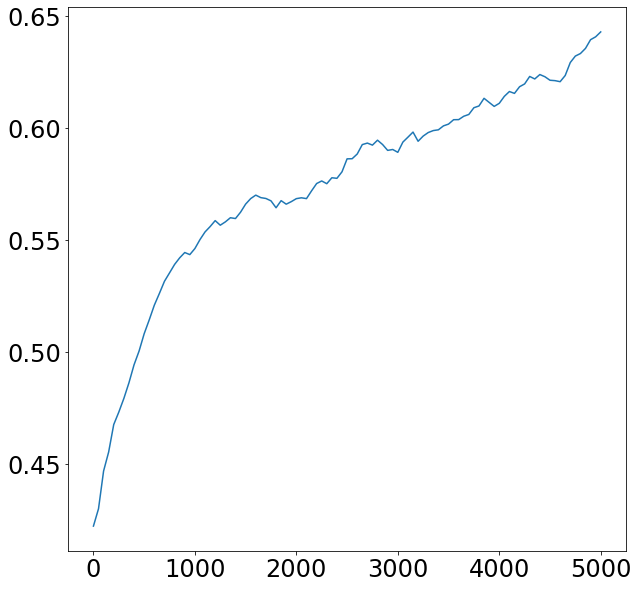

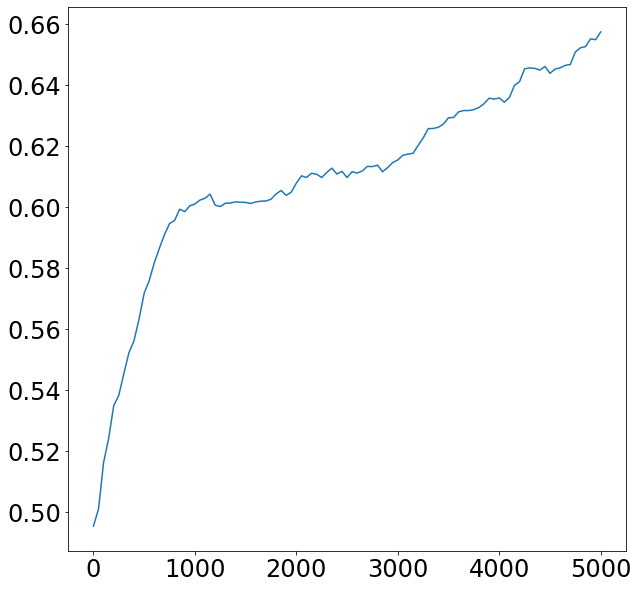

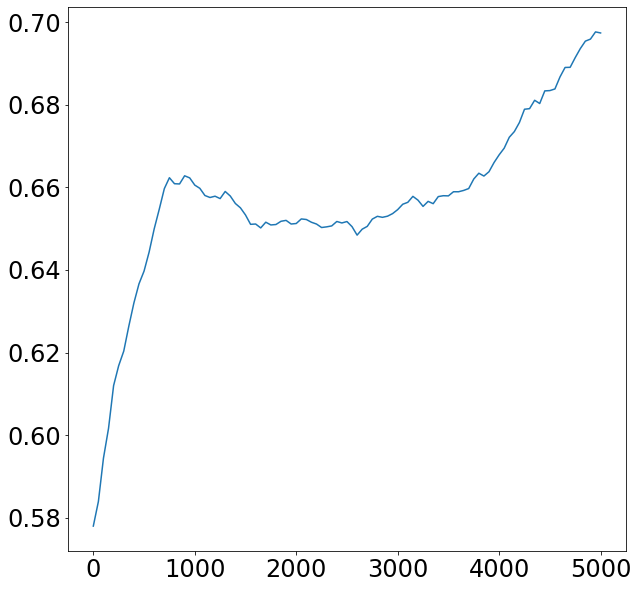

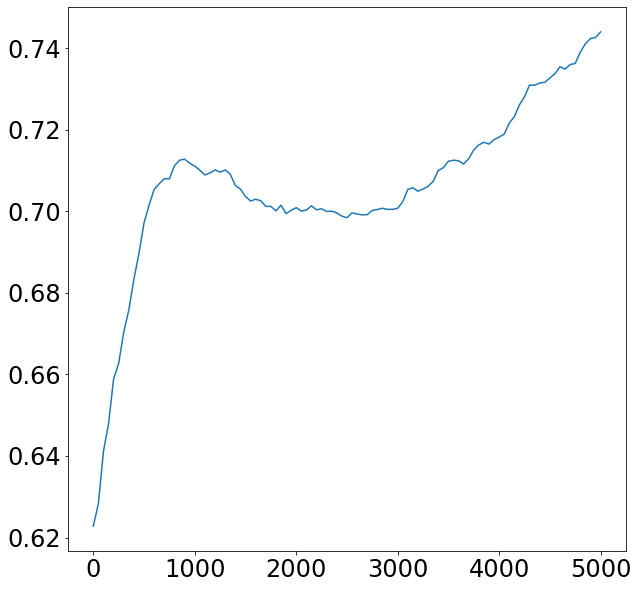

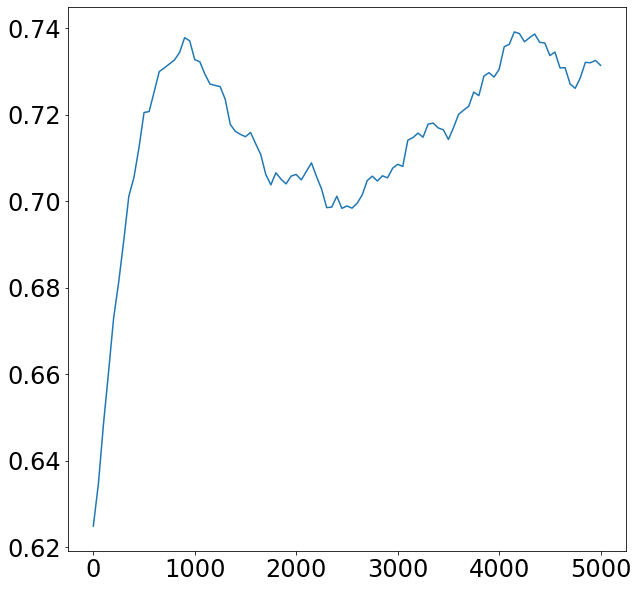

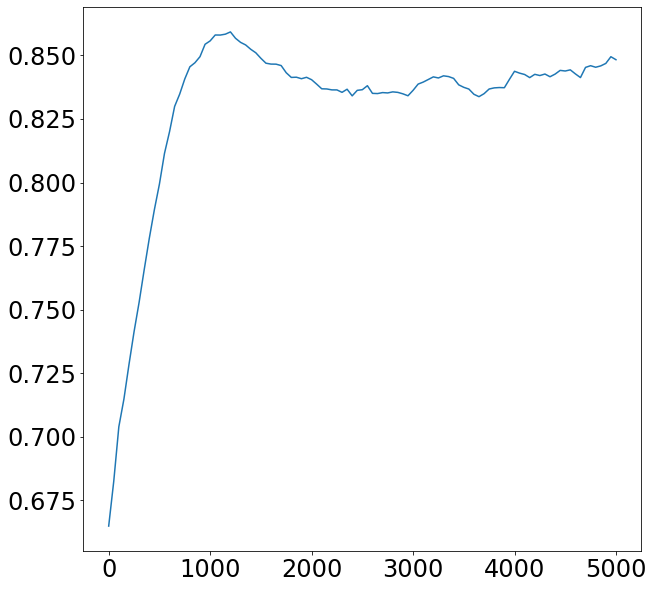

In [351]:
import scipy.stats
for rank in [2,3,4,5,6,7]:
    x = []
    y = []
    adv_lookup = {}
    for adv in range(0, 5001, 50):
        scout_times = {}
        for game, es in engagement_lookup.items():
            if all(x=="GameLength" or infos[game][x].rank != rank for x in infos[game]):
                continue
            es = sorted([e for e in es if e.at_base and e.rel_army > adv], key=lambda e: e.start_time)
            if (len(es) == 0):
                continue            
        #     x.extend([len([e for e in es if e.uid1 == es[0].uid1]), len([e for e in es if e.uid1 == es[0].uid2])])
        #     if not ((es[0].uid1, game) in scouting_lookup_no_engage and (es[0].uid2, game) in scouting_lookup_no_engage):
        #         y.extend([0,0])
        #     else:
        #         for e in es:
        #             timelist = scout_times.setdefault(e.rank1, [])
        #             timelist.append((e.start_time - max((int(x["ScoutingStartTime"])/22.4 for x in scouting[game] 
        #                                                  if x["UID"] == e.uid1 and int(x["ScoutingStartTime"])/22.4 < e.start_time), 
        #                                                 default=0), e.rel_lost))
        #         y.extend([scouting_lookup_no_engage[(es[0].uid1, game)].absolute, scouting_lookup_no_engage[(es[0].uid2, game)].absolute])
            scout_times.setdefault(e.rank1, {}).setdefault('total', 0)
            scout_times[e.rank1]['total'] += 1
            e = es[0]
            if game in scouting and any(x["UID"] == e.uid1 and e.start_time - 180 < int(x["ScoutingEndTime"])/22.4 < e.start_time and
                                        math.dist((float(x["LocationX"]), float(x["LocationY"])), (float(e.x), float(e.y))) < 5000
                                        for x in scouting[game]):
                scout_times.setdefault(e.rank1, {}).setdefault('scout', 0)
                scout_times[e.rank1]['scout'] += 1
        x.append(adv)
        y.append(scout_times[rank]['scout'] / scout_times[rank]['total'])
    print(rank)
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
#     for rank, d in sorted(scout_times.items()):
#         print(rank, d['scout']/d['total'])
# for rank, times in sorted(scout_times.items()):
#     x, y = zip(*times)
#     print(rank, np.mean(x), np.median(y))
#     print(scipy.stats.spearmanr(x, y), scipy.stats.pearsonr(x, y))
#     plt.figure(figsize=(10,10))
#     plt.scatter(x, y, marker='.', alpha=0.1, edgecolors="none")
#     plt.tight_layout()
# x = np.array(x)
# y = np.array(y)
# print(scipy.stats.spearmanr(x, y), scipy.stats.pearsonr(x, y))
# plt.figure(figsize=(10,10))
# plt.scatter(x, y, marker='.', alpha=0.1, edgecolors="none")
# plt.xlim(-5, 100)
# plt.ylim(-5, 30)
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b)
# plt.tight_layout()

In [234]:
print(sorted({rank: np.mean([t for t,r in ts]) for rank, ts in scout_times.items()}.items()))

[(0, 223.88714295027776), (1, 279.5843578527798), (2, 266.1494773567624), (3, 252.04839476322886), (4, 228.6498840808015), (5, 208.63965289074144), (6, 198.61542098011878), (7, 164.4152046213374)]


In [543]:
from itertools import combinations_with_replacement
from textwrap import wrap
from statsmodels.stats.proportion import proportion_confint
import numpy as np

def make_win_plot(ax, wins, xstart, xend, xlabel):
    x = np.array([val for val, w in wins.items()])
    y = np.array([(sum(w)/len(w)) for a, w in wins.items()])
    ci_lowers, ci_uppers = zip(*[proportion_confint(sum(w), len(w), method='wilson') for a, w in wins.items()])
    ax.plot(x, y, linewidth=3)
    ax.fill_between(x, ci_lowers, ci_uppers, color='b', alpha=.1)
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.grid(axis='y')
    ax.set_xlim(xstart, xend)
    ax.set_ylabel("Win probability (95% CI)")
    ax.set_xlabel(xlabel)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

def make_win_plots(lookup: Dict[Tuple[str, str], LookupEntry], data_label: str, ax1, ax2, 
                   pred=lambda x: True, sublabel=None, xlimit=True, xrange=5):
    if sublabel:
        data_label = f"{data_label}\n({sublabel} only)"
    abs_wins = {val: [w for _,w in wins] for val, wins in 
                groupby(sorted([(entry.absolute, entry.win) for entry in lookup.values() if pred(entry)]), 
                        lambda x: x[0])}
    rel_wins = {val: [w for _,w in wins] for val, wins in 
                groupby(sorted([(entry.relative, entry.win) for entry in lookup.values() if pred(entry)]),
                        lambda x: x[0])}
    if xlimit:
        start = list(abs_wins.keys())[next(i for i, (a, w) in enumerate(abs_wins.items()) if 
                                           len(w) >= 50)]
        limit = list(abs_wins.keys())[next(i for i, (a, w) in enumerate(abs_wins.items()) if 
                                           len(w) < 50 and a > np.median(list(abs_wins.keys())))]
        make_win_plot(ax1, abs_wins, start - min(5, limit//10), limit, f"Player's {data_label}")

        limit = list(rel_wins.keys())[next(i for i, (a, w) in enumerate(rel_wins.items()) if 
                                           len(w) < 50 and a > 0)]
        make_win_plot(ax2, rel_wins, -limit, limit, f"Player's Relative {data_label}")
    else:
        make_win_plot(ax1, abs_wins, min(abs_wins) - xrange,
                      max(abs_wins) + xrange, f"Player's {data_label}")
        make_win_plot(ax2, rel_wins, min(rel_wins) - xrange,
                      max(rel_wins) + xrange, f"Player's Relative {data_label}")
    
def make_overall_plots(lookup, data_label, xlimit=True, xrange=5):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
    make_win_plots(lookup, data_label, ax1, ax2, xlimit=xlimit, xrange=xrange)
    plt.tight_layout()
    plt.savefig(f"plots/{data_label}-overall.png")
    
def make_rank_plots(lookup, data_label, xlimit=True, xrange=5):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(3, 6, figsize=(60,30))
    for rank in range(1, 8):
        row = (rank - 1) // 3
        col = (rank - 1) % 3
        make_win_plots(lookup, data_label, axs[row, col], axs[row, col + 3], 
                       lambda x: x.rank == rank, f"Rank {rank}", xlimit=xlimit, xrange=xrange)
    plt.tight_layout()
    plt.savefig(f"plots/{data_label}-rank.png")
    
def make_race_plots(lookup, data_label, xlimit=True, xrange=5):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(2, 3, figsize=(30,20))
    for i, race in enumerate(["Zerg", "Terran", "Protoss"]):
        make_win_plots(lookup, data_label, axs[0, i], axs[1, i], 
                       lambda x: x.race == race, f"Race {race}", xlimit=xlimit, xrange=xrange)
    plt.tight_layout()
    plt.savefig(f"plots/{data_label}-race.png")
    
def make_matchup_plots(lookup, data_label, xlimit=True, xrange=5):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(2, 6, figsize=(60,20))
    for i, (r1, r2) in enumerate(combinations_with_replacement(["Zerg", "Terran", "Protoss"], 2)):
        row = i // 3
        col = i % 3
        make_win_plots(lookup, data_label, axs[row, col], axs[row, col + 3], 
                       lambda x: (x.race == r1 and x.opp_race == r2) or (x.race == r2 and x.opp_race == r1), 
                       f"Matchup {r1}v{r2}", xlimit=xlimit, xrange=xrange)
    plt.tight_layout()
    plt.savefig(f"plots/{data_label}-matchup.png")
    
def print_summary(lookup, data_label):
    by_rank = {rank: [e.absolute for e in list(entries)] for rank, entries in 
                groupby(sorted(lookup.values(), key=lambda e: e.rank), 
                        lambda x: x.rank)}
    print(data_label, "(mean)", "(std)")
    print(f"Overall: {np.mean([e.absolute for e in lookup.values()]):8.4f}\t{np.std([e.absolute for e in lookup.values()]):8.4f}")
    for rank, vals in by_rank.items():
        print(f"Rank {rank:2}: {np.mean(vals):8.4f}\t{np.std(vals):8.4f}")
    
# make_overall_plots(apm_lookup, "APM")
# make_rank_plots(apm_lookup, "APM")
# make_race_plots(apm_lookup, "APM")
# make_matchup_plots(apm_lookup, "APM")
# print_summary(apm_lookup, "APM")

# make_overall_plots(scouting_rate_lookup, "Scouting Rate")
# make_rank_plots(scouting_rate_lookup, "Scouting Rate")
# make_race_plots(scouting_rate_lookup, "Scouting Rate")
# make_matchup_plots(scouting_rate_lookup, "Scouting Rate")
# print_summary(scouting_rate_lookup, "Scouting Rate")

make_overall_plots(scouting_rate_lookup_noengage, "Scouting Rate (non-engagement)")
make_rank_plots(scouting_rate_lookup_noengage, "Scouting Rate (non-engagement)")
make_race_plots(scouting_rate_lookup_noengage, "Scouting Rate (non-engagement)")
make_matchup_plots(scouting_rate_lookup_noengage, "Scouting Rate (non-engagement)")
print_summary(scouting_rate_lookup_noengage, "Scouting Rate (non-engagement)")

# make_overall_plots(cpm_lookup, "CPM")
# make_rank_plots(cpm_lookup, "CPM")
# make_race_plots(cpm_lookup, "CPM")
# make_matchup_plots(cpm_lookup, "CPM")
# print_summary(cpm_lookup, "CPM")

# make_overall_plots(macro_count_lookup, "Macro Rate")
# make_rank_plots(macro_count_lookup, "Macro Rate")
# make_race_plots(macro_count_lookup, "Macro Rate")
# make_matchup_plots(macro_count_lookup, "Macro Rate")
# print_summary(macro_count_lookup, "Macro Rate")

# make_overall_plots(cam_hotkey_lookup, "Camera Hotkey Creation Rate")#, xlimit=False, xrange=0.01)
# make_rank_plots(cam_hotkey_lookup, "Camera Hotkey Creation Rate")#, xlimit=False, xrange=0.01)
# make_race_plots(cam_hotkey_lookup, "Camera Hotkey Creation Rate")#, xlimit=False, xrange=0.01)
# make_matchup_plots(cam_hotkey_lookup, "Camera Hotkey Creation Rate")#, xlimit=False, xrange=0.01)
# print_summary(cam_hotkey_lookup, "Camera Hotkey Creation Rate")

# make_overall_plots(cam_hotkey_usage_lookup, "Camera Hotkey Usage Rate")#, xlimit=False, xrange=0.05)
# make_rank_plots(cam_hotkey_usage_lookup, "Camera Hotkey Usage Rate")#, xlimit=False, xrange=0.05)
# make_race_plots(cam_hotkey_usage_lookup, "Camera Hotkey Usage Rate")#, xlimit=False, xrange=0.05)
# make_matchup_plots(cam_hotkey_usage_lookup, "Camera Hotkey Usage Rate")#, xlimit=False, xrange=0.05)
# print_summary(cam_hotkey_usage_lookup, "Camera Hotkey Usage Rate")

# make_overall_plots(scouting_lookup, "Scouting Instances")
# make_rank_plots(scouting_lookup, "Scouting Instances")
# make_race_plots(scouting_lookup, "Scouting Instances")
# make_matchup_plots(scouting_lookup, "Scouting Instances")

# make_overall_plots(scouting_lookup_no_engage, "Scouting Instances (non-engagement)")
# make_rank_plots(scouting_lookup_no_engage, "Scouting Instances (non-engagement)")
# make_race_plots(scouting_lookup_no_engage, "Scouting Instances (non-engagement)")
# make_matchup_plots(scouting_lookup_no_engage, "Scouting Instances (non-engagement)")

# make_overall_plots(macro_util_lookup, "Macro Utilization", xlimit=False)
# make_rank_plots(macro_util_lookup, "Macro Utilization", xlimit=False)
# make_race_plots(macro_util_lookup, "Macro Utilization", xlimit=False)
# make_matchup_plots(macro_util_lookup, "Macro Utilization", xlimit=False)

plt.close('all')

Scouting Rate (non-engagement) (mean) (std)
Overall:   0.0029	  0.0030
Rank  0:   0.0025	  0.0028
Rank  1:   0.0016	  0.0021
Rank  2:   0.0018	  0.0023
Rank  3:   0.0022	  0.0024
Rank  4:   0.0026	  0.0027
Rank  5:   0.0031	  0.0030
Rank  6:   0.0033	  0.0031
Rank  7:   0.0041	  0.0033


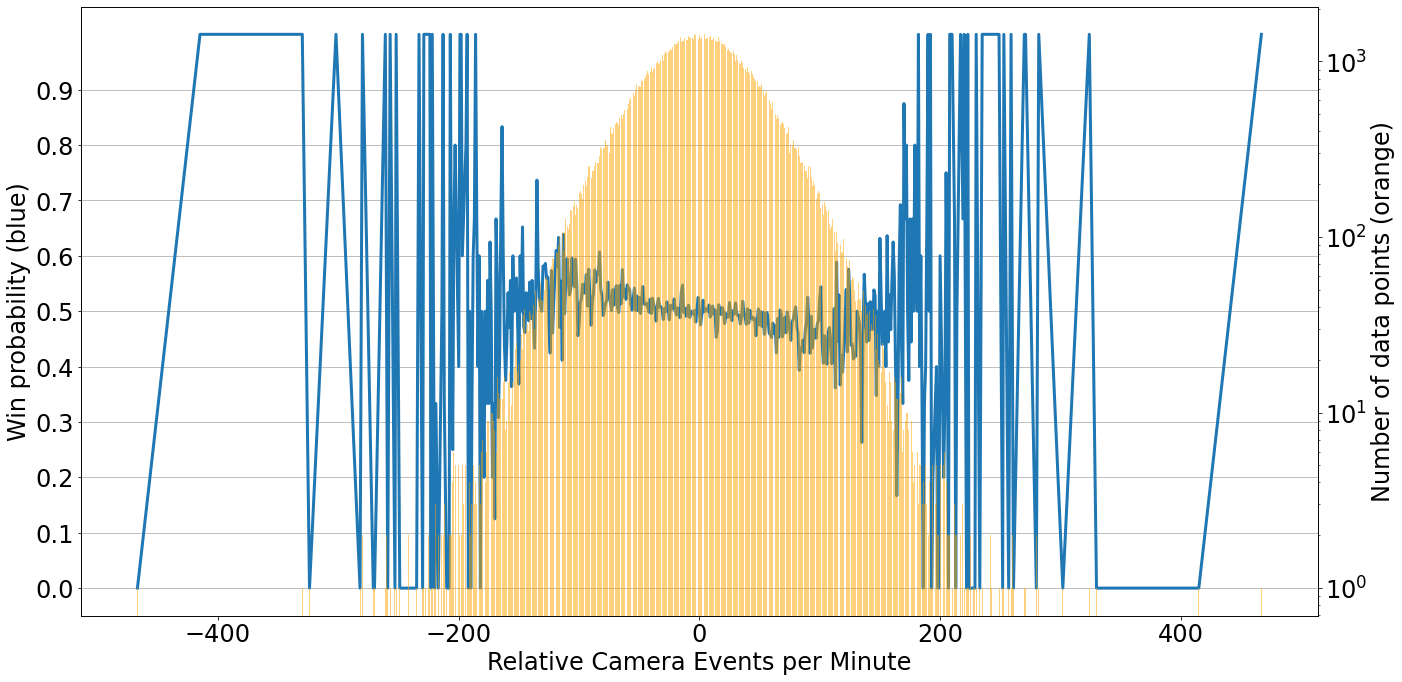

In [81]:
with open("cps2021-07-29.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]

BUCKET_SIZE = 1
rel_cps = {}
for line in lines:
    rel_cps[(line['UID1'], line['GameID'])] = (float(line["CameraPerSec1"])*60//BUCKET_SIZE*BUCKET_SIZE - float(line["CameraPerSec2"])*60//BUCKET_SIZE*BUCKET_SIZE, 1 if line["Winner"] == '1' else 0)
    rel_cps[(line['UID2'], line['GameID'])] = (float(line["CameraPerSec2"])*60//BUCKET_SIZE*BUCKET_SIZE - float(line["CameraPerSec1"])*60//BUCKET_SIZE*BUCKET_SIZE, 1 if line["Winner"] == '2' else 0)
    
cps_wins = {cps: [int(w) for a,w in wins] for cps, wins in groupby(sorted([(cps, win) for (uid, game), (cps, win) in rel_cps.items()]), lambda x: x[0])}

plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
fig, ax = plt.subplots(figsize=(20,10))

ax.plot([a for a, w in cps_wins.items()], [(sum(w)/len(w)) for a, w in cps_wins.items()], linewidth=3)
ax.set_yticks(np.arange(0, 1, 0.1))
# ax.set_xlim(-100, 100)
# ax.set_xticks(np.arange(-500, 500, APM_BUCKET_SIZE))
ax.grid(axis='y')
ax_bar = ax.twinx()
ax_bar.bar(list(cps_wins.keys()), [len(w) for a, w in cps_wins.items()], color='orange', alpha=0.5)
ax_bar.set_yscale('log')
ax.set_ylabel("Win probability (blue)")
ax_bar.set_ylabel("Number of data points (orange)")
ax.set_xlabel("Relative Camera Events per Minute")
plt.tight_layout()

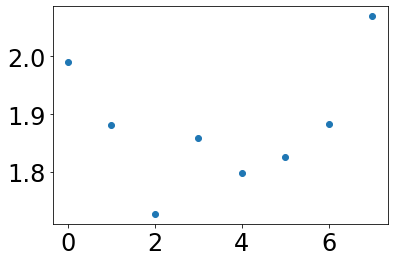

In [93]:
c1 = {key: [float(x['CameraPerSec1']) for x in g] for key, g in groupby(sorted(lines, key=lambda x: x['Rank1']), lambda x: x['Rank1'])}
c2 = {key: [float(x['CameraPerSec2']) for x in g] for key, g in groupby(sorted(lines, key=lambda x: x['Rank2']), lambda x: x['Rank2'])}
c = {k1: g1 + g2 for ((k1, g1), (k2, g2)) in zip(c1.items(), c2.items())}

plt.scatter([int(k) for k in c], [np.mean(v) for v in c.values()])

([<matplotlib.axis.XTick at 0x19039fe50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

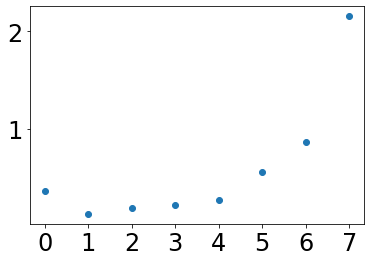

In [112]:
d = sorted([(key, [float(x['CPS']) for x in g]) for key, g in groupby(sorted([s for a in stats.values() for s in a], key=lambda x: x['Rank']), lambda x: x['Rank'])], key=lambda x: x[0])
plt.scatter([int(a) if a != 'nan' else 0 for a, _ in d], [np.mean(v) for _, v in d])
plt.xticks(np.arange(0, 8, 1))

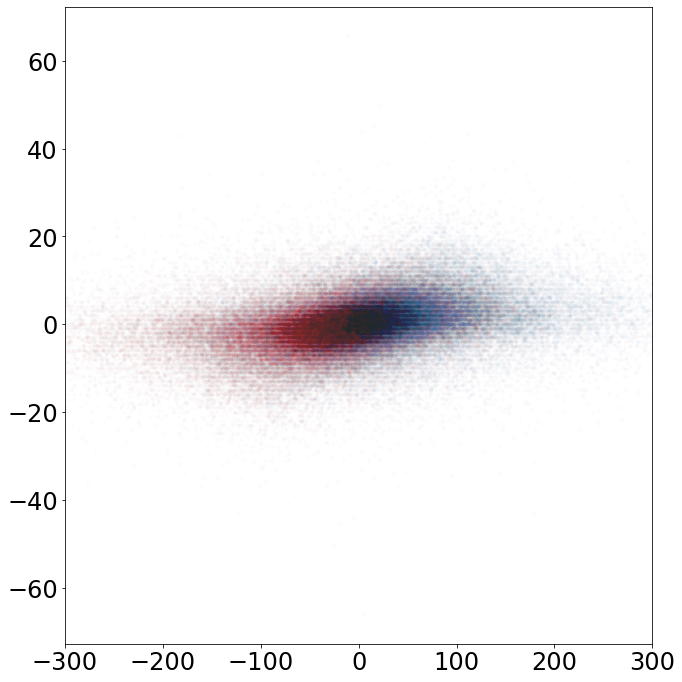

In [137]:
counts = []
rates = []
colors = []
color_pal = ['tab:red', 'tab:blue']
for game in apm_lookup:
    counts.append(apm_lookup[game].relative + np.random.normal(0, 3))
    rates.append((cam_hotkey_lookup[game].relative if game in cam_hotkey_lookup else 0) + np.random.normal(0, 0.2))
#     if rates[-1] != 0:
#         rates[-1] += np.random.random() * 0.001
    colors.append(color_pal[apm_lookup[game].win])
    
plt.figure(figsize=(10,10))
plt.scatter(counts, rates, c=colors, marker='.', edgecolors=None, alpha=0.01)
plt.xlim(-300, 300)
plt.tight_layout()